In [1]:
#!pip3 install scikit-learn
#!pip3 install krippendorff
#!pip3 install diptest
#!pip3 install termcolor

In [2]:
from __future__ import division
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict, Counter
from itertools import chain, combinations
from random import seed, shuffle
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import roc_auc_score

from preprocess_classification_datasets import load_preprocessed_classification_data, preprocess_all_datasets
from classification import train_classifier, make_predictions, calculate_evaluation_metrics, characterize_mistakes_per_rating, characterize_mistakes_per_worker
from consensus import calculate_concensus

In [3]:
DATA_FOLDER = "../data/"

In [4]:
def print_table(results):
    table_text = ""
    table_text += "Rating"
    for key in sorted(results):
        table_text += " & {}".format(key)
    table_text += "\\\\\n"

    titles = ["Total num", "Fraction Misclassified", "Avg Prob Correct Class", "Std Of Prob Correct Class"]
    keys = ["num_instances", "frac_misclassified", "avg_prob", "std_prob"]

    for i, title in enumerate(titles):
        table_text += "{}".format(title)
        for key in sorted(results):
            table_text += " & {}".format(results[key][keys[i]])
        table_text += "\\\\\n"

    print(table_text)

In [5]:
def print_cdf(results):
    for i, j in results:
        print("{}, {}".format(i, round(j, 2)))

In [6]:
def demo():
    frac_train = 0.5
    random_seed = 560
    dataset_prefix = "AMT" # choose between "AMT", "AMT_wo_neutral", "SSI", "SSI_wo_neutral"
    data_subset = "test" # choose between "all", "train", "test"
    features = ['volitionality', 'reliability', 'privacy', 'relevance', 'causes_outcome', 'caused_by_sensitive_feature', 'causal_loop', 'causes_disparity_in_outcomes']
    control_features = ["fairness", "worker"]

    # load preprocessed dataset
    preprocess_all_datasets()
    data = load_preprocessed_classification_data(dataset_prefix, show_preview=False)


    # CLASSIFICATION
    # train & evaluate classifiers
    accuracy_cv, auc_cv = list(), list()
    for i in range(0, 5):
        random_seed -= 1
        # train classifier
        clsfr = train_classifier(data, features, control_features, frac_train=frac_train, random_seed=random_seed)    
        # make predictions
        ground_truth, predicted, predicted_prob, fairness_control, worker_control = make_predictions(clsfr, data, "test", features, control_features, frac_train=frac_train, random_seed=random_seed)    
        ## accuracy & auc
        accuracy, auc = calculate_evaluation_metrics(ground_truth, predicted)
        accuracy_cv.append(accuracy)
        auc_cv.append(auc)

    print("Average accuracy: ", np.average(np.array(accuracy_cv)))
    print("Average AUC: ", np.average(np.array(auc_cv)))

    # characterize misclassifications
    ## evaluate on whole data
    ground_truth, predicted, predicted_prob, fairness_control, worker_control = make_predictions(clsfr, data, "all", features, control_features, frac_train=frac_train, random_seed=random_seed)    
    
    ## missclassifications per fairness rating
    rating_mistakes = characterize_mistakes_per_rating(ground_truth, predicted, predicted_prob, fairness_control)
    print("\n\nCharacterize misclassifications per fairness rating\n")
    print_table(rating_mistakes)

    ## misclassifications per worker
    print("\n\nCharacterize misclassifications per worker (CDF)\n")
    worker_mistakes_cdf = characterize_mistakes_per_worker(ground_truth, predicted, worker_control)
    print_cdf(worker_mistakes_cdf)


    # CONSENSUS
    clsfr = train_classifier(data, features, control_features, frac_train=frac_train, random_seed=555)
    ground_truth, predicted, predicted_prob, fairness_control, worker_control = make_predictions(clsfr, data, "all", features, control_features, frac_train=frac_train, random_seed=random_seed)    
    data["predicted_fairness"] = predicted


    CRED = '\033[91m'
    CEND = '\033[0m'
    print(CRED + "########TEST TEST TEST START########")
    dict_data = data
    print(type(data))
    print(data)
    df_print = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in data.items() ]))
    df_print.to_excel('df_print.xlsx')
    with open('df_print.txt','w') as d: 
        d.write(str(data))
    print("########TEST TEST TEST END########" + CEND)
    
    
    concensus = calculate_concensus(data)
    
    

In [7]:
dict_data = {}
def main():
    demo()
         
    
if __name__=="__main__":
    main()

Average accuracy:  0.8989795918367347
Average AUC:  0.8974442441239316


Characterize misclassifications per fairness rating

Rating & 1 & 2 & 3 & 4 & 5 & 6 & 7\\
Total num & 391 & 249 & 195 & 136 & 321 & 280 & 388\\
Fraction Misclassified & 0.06 & 0.16 & 0.36 & 0.32 & 0.08 & 0.04 & 0.01\\
Avg Prob Correct Class & 0.89 & 0.75 & 0.58 & 0.61 & 0.81 & 0.9 & 0.97\\
Std Of Prob Correct Class & 0.19 & 0.25 & 0.28 & 0.29 & 0.2 & 0.15 & 0.08\\



Characterize misclassifications per worker (CDF)

0.0, 0.0
0.1, 0.0
0.2, 0.01
0.3, 0.01
0.4, 0.01
0.5, 0.02
0.6, 0.06
0.7, 0.12
0.8, 0.29
0.9, 0.6
1.0, 1.0
########TEST TEST TEST START########
<class 'dict'>
{'classification_features': ['volitionality', 'reliability', 'privacy', 'relevance', 'causes_outcome', 'caused_by_sensitive_feature', 'causal_loop', 'causes_disparity_in_outcomes', 'feature', 'worker'], 'continuous_features': ['volitionality', 'reliability', 'privacy', 'relevance', 'causes_outcome', 'caused_by_sensitive_feature', 'causal_loop', 'c

# CALCULATION SHANON ENTROPHY

In [8]:
import numpy as np
import math
from math import log2
from scipy.stats import entropy

In [9]:
rating_feature01 = np.array([0.01, 0.01, 0.01, 0.03, 0.12, 0.18, 0.65])
rating_feature02 = np.array([0.02, 0.01, 0.01, 0.03, 0.08, 0.22, 0.64])
rating_feature03 = np.array([0.08, 0.07, 0.10, 0.07, 0.26, 0.22, 0.20])
rating_feature04 = np.array([0.13, 0.05, 0.11, 0.09, 0.26, 0.24, 0.12])
rating_feature05 = np.array([0.16, 0.18, 0.11, 0.10, 0.22, 0.12, 0.12])
rating_feature06 = np.array([0.22, 0.12, 0.16, 0.09, 0.20, 0.11, 0.09])
rating_feature07 = np.array([0.28, 0.21, 0.15, 0.07, 0.12, 0.10, 0.08])
rating_feature08 = np.array([0.38, 0.21, 0.09, 0.07, 0.13, 0.10, 0.03])
rating_feature09 = np.array([0.38, 0.20, 0.12, 0.07, 0.12, 0.08, 0.03])
rating_feature10 = np.array([0.34, 0.22, 0.14, 0.08, 0.13, 0.06, 0.03])

In [10]:
def sne2_calc(FEATURE):
    Hn = []
    for i in FEATURE:
        Hi = -i * math.log(i,math.e)
        Hn.append(Hi)    
    SNE = sum(Hn)/math.log(7,math.e)
    return (1-SNE)

In [11]:
print(sne2_calc(rating_feature01))
print(sne2_calc(rating_feature02))
print(sne2_calc(rating_feature03))
print(sne2_calc(rating_feature04))
print(sne2_calc(rating_feature05))
print(sne2_calc(rating_feature06))
print(sne2_calc(rating_feature07))
print(sne2_calc(rating_feature08))
print(sne2_calc(rating_feature09))
print(sne2_calc(rating_feature10))

0.44167202175941156
0.43659745046010345
0.06992209325287935
0.06382657715771489
0.014904746859083384
0.034451414352580145
0.05358886032661714
0.12690459051706515
0.130568288044962
0.11792044152254078


In [12]:
def sne_calc(FEATURE):
    Hn = []
    for i in FEATURE:
        Hi = -i * np.log2(i)
        Hn.append(Hi)    
    SNE = sum(Hn)/log2(7)
    return (1-SNE)

In [13]:
print(sne_calc(rating_feature01))
print(sne_calc(rating_feature02))
print(sne_calc(rating_feature03))
print(sne_calc(rating_feature04))
print(sne_calc(rating_feature05))
print(sne_calc(rating_feature06))
print(sne_calc(rating_feature07))
print(sne_calc(rating_feature08))
print(sne_calc(rating_feature09))
print(sne_calc(rating_feature10))

0.44167202175941156
0.43659745046010345
0.06992209325287957
0.06382657715771478
0.014904746859083162
0.03445141435258037
0.05358886032661725
0.12690459051706515
0.130568288044962
0.11792044152254089


In [14]:
#Gini coefficient is a way to measure the income distribution of a population.
# 0 (perfect income inequality)
# 1 (perfect income equality (everyone has the same income))
def gini_calc(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
        GINI = total / (len(x)**2 * np.mean(x))
    return (1-GINI)

In [15]:
print(gini_calc(rating_feature01))
print(gini_calc(rating_feature02))
print(gini_calc(rating_feature03))
print(gini_calc(rating_feature04))
print(gini_calc(rating_feature05))
print(gini_calc(rating_feature06))
print(gini_calc(rating_feature07))
print(gini_calc(rating_feature08))
print(gini_calc(rating_feature09))
print(gini_calc(rating_feature10))

0.3295615275813297
0.3295615275813297
0.7171428571428571
0.7285714285714285
0.8472418670438473
0.8095238095238095
0.734087694483734
0.6124469589816126
0.6142857142857143
0.6257142857142858


In [16]:
# Cohen's kappa coefficient is a statistic that is used to measure inter-rater reliability for qualitative items.
# Cohen’s Kappa is used to measure the level of agreement between two raters or judges who each classify items into mutually exclusive categories.
from sklearn.metrics import cohen_kappa_score
#cohen_kappa_score(rating_feature01, rating_feature02)

In [17]:
import pandas as pd
NOWdf = pd.read_excel(r'/Users/nursatkakon/Desktop/project_code/code/nse-gini.xlsx')
NOWdf = NOWdf.set_index('Feature')
NOWdf['Feature'] = NOWdf.index
NOWdf

,No,1,2,3,4,5,6,7,1_NSE_7pt,1_NSE_7pt_loge,1_NSE_7pt_log2,1_GINI_7pt,Feature
Feature,,,,,,,,,,,,,
Current Charges,1,0.01,0.01,0.01,0.03,0.12,0.18,0.65,0.46,0.441672,0.441672,0.329562,Current Charges
Criminal History: self,2,0.02,0.01,0.01,0.03,0.08,0.22,0.64,0.45,0.436597,0.436597,0.329562,Criminal History: self
Substance Abuse,3,0.08,0.07,0.10,0.07,0.26,0.22,0.20,0.07,0.069922,0.069922,0.717143,Substance Abuse
Stability of Employment,4,0.13,0.05,0.11,0.09,0.26,0.24,0.12,0.06,0.063827,0.063827,0.728571,Stability of Employment
Personality,5,0.16,0.18,0.11,0.10,0.22,0.12,0.12,0.02,0.014905,0.014905,0.847242,Personality
Criminal Attitudes,6,0.22,0.12,0.16,0.09,0.20,0.11,0.09,0.03,0.034451,0.034451,0.809524,Criminal Attitudes
Neighborhood Safety,7,0.28,0.21,0.15,0.07,0.12,0.10,0.08,0.06,0.053589,0.053589,0.734088,Neighborhood Safety
Criminal History: family and friends,8,0.38,0.21,0.09,0.07,0.13,0.10,0.03,0.13,0.126905,0.126905,0.612447,Criminal History: family and friends
Quality of Social Life & Free Time,9,0.38,0.20,0.12,0.07,0.12,0.08,0.03,0.13,0.130568,0.130568,0.614286,Quality of Social Life & Free Time


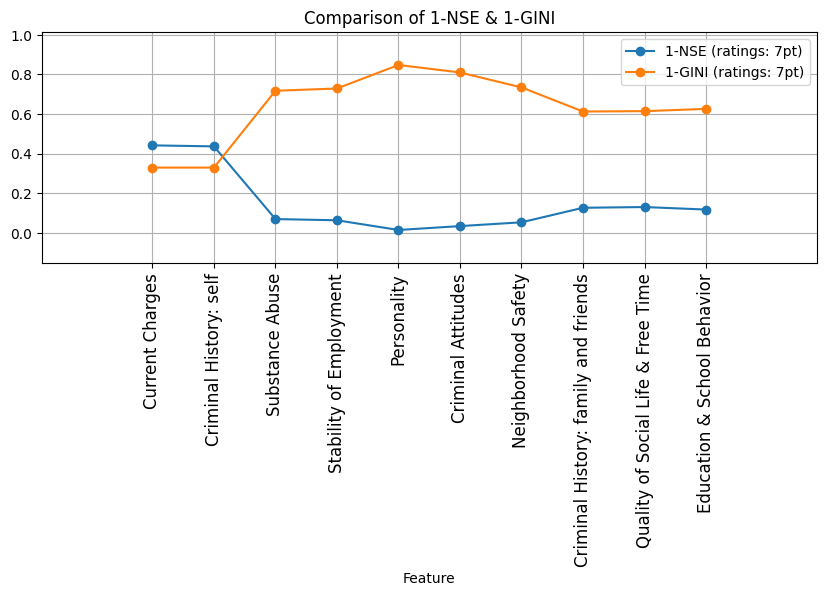

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

#plt.style.use('seaborn-white')

# plot multiple columns such as population and year from dataframe
NOWdf.plot(x="Feature", y=["1_NSE_7pt_log2", "1_GINI_7pt"],
           grid=True,
           title='Comparison of 1-NSE & 1-GINI',
           marker='o',
           #kind="line", 
           figsize=(10, 3))
 
index = [
    "Current Charges",
    "Criminal History: self",
    "Substance Abuse",
    "Stability of Employment",
    "Personality",
    "Criminal Attitudes",
    "Neighborhood Safety",
    "Criminal History: family and friends",
    "Quality of Social Life & Free Time",
    "Education & School Behavior",]
plt.margins(0.2)
plt.xticks(list(range(len(index))), NOWdf.index, fontsize=12, rotation=90)
plt.legend(['1-NSE (ratings: 7pt)', '1-GINI (ratings: 7pt)'])
plt.show()